<h1><strong>Predicting Drug Overdose Rates by Demographics<strong/></h1>
<hr>
<h3><em> Arona Cho (aronacho@uw.edu), Caleb Lykken (lykken@uw.edu), Ryan Nishi (rnishi@uw.edu)</em> <h3/>

<h4> Model Masters for DubTech Datathon 2024 <h4/>



<h2>Objectives<h2/>
<p>
Develop a predictive model to forecast future drug overdose death rates for each demographic group.

Build a machine learning model to identify individuals or demographics at the highest risk of drug overdose deaths. Use features like drug type, age, sex, race, and Hispanic origin.
<p/>

<h2>Motivation<h1/>
<p>
As students that live in the Seattle area, drugs are a common topic in our everyday conversations due to the large number of the homeless population that resides in our city. Visually, drug addiction within our neighborhoods is apparent. Needles can be seen on our sidewalks with people idly standing with muscle-rigidity. As members of the community, we are encouraged to carry naloxone, a medicine that reverses the effects of various drug overdoses. Through this project, we hope to go beyond aesthetics and dive deeper into various indicators of drug overdoses, which will ultimately expand our understanding about which factors and traits seem to be the most susceptible to overdoses.
<p/>
<h2>Data Setting and Context<h1/>

<p>
This data was provided by the National Center for Health Statistics, and accessed from the Center for Disease Control's website, which supports the validity of the data. The years from dataset span from 1999 to 2018, which results in approximately 18 years of data to analyze. The NCHS pulls their data from death and medcal records, meaning that the population that is encapsulated by this dataset would be those whose death and medical situations have been institutionally filed by within the United States. Possible biases may against populations that live in homelessness, poverty, or exclusion, as death records require either a form of identification or an identifier, and if a body is neglected long enough, the body be visually unidentifiable.
<p/>

<h2>Method<h1/>

<p>
1. Prepare for data to be used in the machine learning model by cleaning the data from unwanted variables and reformatting the dataset to account for categorical variables.  

2. Define a machine learning model with the boosted tree model using target and feature variables from the cleaned dataset.

3. Perform a feature selection to identify what variables are the most powerful in informing our model, and comparatively, what variables are the least neccessary.

4. Perform a grid search to aid in fine-tuning our model, by picking out the most optimal combination of hyper-parameters for predicting.

<p/>  

<hr>
<h2> Imports and Reading Data <h2/>
<hr>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

#!pip install -q keras tensorflow-cpu

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States_20240518 - Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States_20240518.csv")
df.head()

INDICATOR                     PANEL  PANEL_NUM  \
0  Drug overdose death rates  All drug overdose deaths          0   
1  Drug overdose death rates  All drug overdose deaths          0   
2  Drug overdose death rates  All drug overdose deaths          0   
3  Drug overdose death rates  All drug overdose deaths          0   
4  Drug overdose death rates  All drug overdose deaths          0   

                                                UNIT  UNIT_NUM STUB_NAME  \
0  Deaths per 100,000 resident population, age-ad...         1     Total   
1  Deaths per 100,000 resident population, age-ad...         1     Total   
2  Deaths per 100,000 resident population, age-ad...         1     Total   
3  Deaths per 100,000 resident population, age-ad...         1     Total   
4  Deaths per 100,000 resident population, age-ad...         1     Total   

   STUB_NAME_NUM   STUB_LABEL  STUB_LABEL_NUM  YEAR  YEAR_NUM       AGE  \
0              0  All persons             0.1  1999         1  All ages   
1              0  All persons             0.1  2000         2  All ages   
2              0  All persons             0.1  2001         3  All ages   
3              0  All persons             0.1  2002         4  All ages   
4              0  All persons             0.1  2003         5  All ages   

   AGE_NUM  ESTIMATE FLAG  
0      1.1       6.1  NaN  
1      1.1       6.2  NaN  
2      1.1       6.8  NaN  
3      1.1       8.2  NaN  
4      1.1       8.9  NaN

<hr>
<h2> Data Cleaning <h2/>
<p> Filtering and reformatting the dataframe to most suitable for machine learning is crucial in creating a model that is correctly and sensibly informed by the dataframe.

In this portion we include:
- Converting categorical variables to dummy columns
  
- Dropping unneeded rows and columns
  - A major formatting adjustment performed was the seperattion of the STUB_LABEL column into distinct race columns to achieve a more streamlined and independent labelling of columns. Before, multiple races were placed in comparison to one another in one column, resulting in a relational dataset that gave less room for dissecting each race's chance of overdose.
  - Age-adjusted rows of data seemed to better inform our predictive model rather than the crude rows of data, as age-adjustment "ensures that differences in incidence or deaths from one year to another, or between one geographic area and another, are not due to differences in the age distribution of the populations being compared." <a href="https://www.cdc.gov/cancer/uscs/technical_notes/stat_methods/rates.htm#:~:text=Crude%20Rates%20vs.&text=Age%2Dadjusting%20the%20rates%20ensures,of%20the%20populations%20being%20compared.">(CDC)<a/>
  <p>Rows with crude rates were subsequently dropped.<p/>
<p/>

<hr>

In [4]:
# Converting the FLAG column to dummies
# NaN -> 0
# * -> 1
df['FLAG_BOOL'] = pd.get_dummies(df['FLAG'])
df['FLAG_BOOL'] = [int(i) for i in df['FLAG_BOOL']]

In [5]:
# Dropping rows with no death estimates
df = df[df['ESTIMATE'].notna()]

In [6]:
# Converting categorical columns ('AGE', 'STUB_NAME', 'PANEL', 'UNIT') into dummy columns

category_column_names = ['AGE', 'STUB_NAME', 'PANEL', 'UNIT'] #'YEAR'

for name in category_column_names:
  all_labels = df[name].unique()
  for label in all_labels:
    df.loc[:, label] = np.where(df.loc[:, name] == label, 1, 0)

In [7]:
# Splitting the STUB_LABELs columns into respective race groups

all_labels = ['All persons', 'Male', 'Female', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian or Pacific Islander', 'All races', 'Not Hispanic or Latino']
for label in all_labels:
    df.loc[:, label] = np.where(df.loc[:, 'STUB_LABEL'].str.contains(label), 1, 0)

df.loc[:, 'Hispanic or Latino'] = np.where(~df.loc[:, 'STUB_LABEL'].str.contains('Not') & df.loc[:, 'STUB_LABEL'].str.contains('Hispanic or Latino'), 1, 0)

In [8]:
# Checking to see if 'Hispanic or Latino' is properly labeled
df[['Hispanic or Latino', 'STUB_LABEL']].sample(10)

Hispanic or Latino                                         STUB_LABEL
2303                   1              Female: Hispanic or Latino: All races
3837                   0                                Female: 35-44 years
2262                   0  Male: Not Hispanic or Latino: American Indian ...
849                    0                                Female: 15-24 years
2524                   0                                        55-64 years
1048                   0                                        Male: White
888                    0                                Female: 35-44 years
5627                   0                                  Male: 25-34 years
3010                   0                                             Female
2985                   0                                               Male

In [9]:
# Dropping improper categorical columns and other redundant columns
df = df.drop(['AGE', 'STUB_NAME', 'STUB_LABEL', 'PANEL', 'UNIT', 'AGE_NUM', 'STUB_LABEL', 'STUB_NAME_NUM', 'STUB_LABEL_NUM', 'PANEL_NUM', 'UNIT_NUM', 'YEAR_NUM', 'INDICATOR', 'FLAG'], axis=1)

In [10]:
# Visual inspection of resulting dataframe
df.head()

YEAR  ESTIMATE  FLAG_BOOL  All ages  Under 15 years  15-24 years  \
0  1999       6.1          0         1               0            0   
1  2000       6.2          0         1               0            0   
2  2001       6.8          0         1               0            0   
3  2002       8.2          0         1               0            0   
4  2003       8.9          0         1               0            0   

   25-34 years  35-44 years  45-54 years  55-64 years  ...  All persons  Male  \
0            0            0            0            0  ...            1     0   
1            0            0            0            0  ...            1     0   
2            0            0            0            0  ...            1     0   
3            0            0            0            0  ...            1     0   
4            0            0            0            0  ...            1     0   

   Female  White  Black or African American  American Indian or Alaska Native  \
0       0      0                          0                                 0   
1       0      0                          0                                 0   
2       0      0                          0                                 0   
3       0      0                          0                                 0   
4       0      0                          0                                 0   

   Asian or Pacific Islander  All races  Not Hispanic or Latino  \
0                          0          0                       0   
1                          0          0                       0   
2                          0          0                       0   
3                          0          0                       0   
4                          0          0                       0   

   Hispanic or Latino  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 39 columns]

In [11]:
# Filtering the dataframe to only include rows with age-adjusted rates
age_adj_df = df[df['Deaths per 100,000 resident population, age-adjusted'] == 1]
age_adj_df

YEAR  ESTIMATE  FLAG_BOOL  All ages  Under 15 years  15-24 years  \
0     1999       6.1          0         1               0            0   
1     2000       6.2          0         1               0            0   
2     2001       6.8          0         1               0            0   
3     2002       8.2          0         1               0            0   
4     2003       8.9          0         1               0            0   
...    ...       ...        ...       ...             ...          ...   
6190  2018       0.5          0         1               0            0   
6192  2018       1.1          0         1               0            0   
6193  2018       3.0          0         1               0            0   
6194  2018       2.4          0         1               0            0   
6195  2018       2.7          0         1               0            0   

      25-34 years  35-44 years  45-54 years  55-64 years  ...  All persons  \
0               0            0            0            0  ...            1   
1               0            0            0            0  ...            1   
2               0            0            0            0  ...            1   
3               0            0            0            0  ...            1   
4               0            0            0            0  ...            1   
...           ...          ...          ...          ...  ...          ...   
6190            0            0            0            0  ...            0   
6192            0            0            0            0  ...            0   
6193            0            0            0            0  ...            0   
6194            0            0            0            0  ...            0   
6195            0            0            0            0  ...            0   

      Male  Female  White  Black or African American  \
0        0       0      0                          0   
1        0       0      0                          0   
2        0       0      0                          0   
3        0       0      0                          0   
4        0       0      0                          0   
...    ...     ...    ...                        ...   
6190     1       0      0                          0   
6192     0       1      0                          0   
6193     0       1      1                          0   
6194     0       1      0                          0   
6195     0       1      0                          0   

      American Indian or Alaska Native  Asian or Pacific Islander  All races  \
0                                    0                          0          0   
1                                    0                          0          0   
2                                    0                          0          0   
3                                    0                          0          0   
4                                    0                          0          0   
...                                ...                        ...        ...   
6190                                 0                          0          0   
6192                                 0                          0          1   
6193                                 0                          0          0   
6194                                 0                          0          0   
6195                                 1                          0          0   

      Not Hispanic or Latino  Hispanic or Latino  
0                          0                   0  
1                          0                   0  
2                          0                   0  
3                          0                   0  
4                          0                   0  
...                      ...                 ...  
6190                       1                   0  
6192                       0                   1  
6193                       1                   0  
6194                       1        

<hr>
<h2> Machine Learning Model <h2/>
<p>
Defining our target variable and features that may possibly be helpful with training our model.
<p/>
<hr>

In [ ]:
# Current columns
df.columns

Index(['YEAR', 'ESTIMATE', 'FLAG_BOOL', 'All ages', 'Under 15 years',
       '15-24 years', '25-34 years', '35-44 years', '45-54 years',
       '55-64 years', '65-74 years', '75-84 years', '85 years and over',
       'Total', 'Sex', 'Sex and race', 'Sex and race and Hispanic origin',
       'Age', 'Sex and age', 'Sex and race (single race)',
       'Sex and race and Hispanic origin (single race)',
       'All drug overdose deaths', 'Drug overdose deaths involving any opioid',
       'Drug overdose deaths involving natural and semisynthetic opioids',
       'Drug overdose deaths involving methadone',
       'Drug overdose deaths involving other synthetic opioids (other than methadone)',
       'Drug overdose deaths involving heroin',
       'Deaths per 100,000 resident population, age-adjusted',
       'Deaths per 100,000 resident population, crude', 'All persons', 'Male',
       'Female', 'White', 'Black or African American',
       'American Indian or Alaska Native', 'Asian or Pacific

In [ ]:
# Defining our target variable and dropping uneeded features
target = 'ESTIMATE'
features = age_adj_df.drop(['ESTIMATE', 'Deaths per 100,000 resident population, crude',], axis =1)
features = features.columns.to_list()

In [ ]:
# Resulting columns
df = age_adj_df
df.columns

Index(['YEAR', 'ESTIMATE', 'FLAG_BOOL', 'All ages', 'Under 15 years',
       '15-24 years', '25-34 years', '35-44 years', '45-54 years',
       '55-64 years', '65-74 years', '75-84 years', '85 years and over',
       'Total', 'Sex', 'Sex and race', 'Sex and race and Hispanic origin',
       'Age', 'Sex and age', 'Sex and race (single race)',
       'Sex and race and Hispanic origin (single race)',
       'All drug overdose deaths', 'Drug overdose deaths involving any opioid',
       'Drug overdose deaths involving natural and semisynthetic opioids',
       'Drug overdose deaths involving methadone',
       'Drug overdose deaths involving other synthetic opioids (other than methadone)',
       'Drug overdose deaths involving heroin',
       'Deaths per 100,000 resident population, age-adjusted',
       'Deaths per 100,000 resident population, crude', 'All persons', 'Male',
       'Female', 'White', 'Black or African American',
       'American Indian or Alaska Native', 'Asian or Pacific

In [ ]:
# train and test on log values to help deal with distribution of data.
X = df[features]
y = np.log(df[target])

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


<hr>
<h2> Grid Search <h2/>

<p>
Grid searching was performed to find the most optimal hyper parameters for our predictive model.

Through our Grid Search, we found that the best parameters are:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
<p/>
<hr>

In [ ]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert negative MSE to RMSE

print("Best parameters:", best_params)
print("Best RMSE:", best_score)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Best RMSE: 0.2616217973888522


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)

[0]	validation_0-rmse:1.06735
[1]	validation_0-rmse:0.92671
[2]	validation_0-rmse:0.81102
[3]	validation_0-rmse:0.72720
[4]	validation_0-rmse:0.66250
[5]	validation_0-rmse:0.60646
[6]	validation_0-rmse:0.57051
[7]	validation_0-rmse:0.52727
[8]	validation_0-rmse:0.50137
[9]	validation_0-rmse:0.47704
[10]	validation_0-rmse:0.43891
[11]	validation_0-rmse:0.40955
[12]	validation_0-rmse:0.39473
[13]	validation_0-rmse:0.37409
[14]	validation_0-rmse:0.36020
[15]	validation_0-rmse:0.34692
[16]	validation_0-rmse:0.34071
[17]	validation_0-rmse:0.33179
[18]	validation_0-rmse:0.32480
[19]	validation_0-rmse:0.32069
[20]	validation_0-rmse:0.31535
[21]	validation_0-rmse:0.30917
[22]	validation_0-rmse:0.30245
[23]	validation_0-rmse:0.30074
[24]	validation_0-rmse:0.29845
[25]	validation_0-rmse:0.29701
[26]	validation_0-rmse:0.29423
[27]	validation_0-rmse:0.29389
[28]	validation_0-rmse:0.29190
[29]	validation_0-rmse:0.28819


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:0.28730
[31]	validation_0-rmse:0.28660
[32]	validation_0-rmse:0.28644
[33]	validation_0-rmse:0.28295
[34]	validation_0-rmse:0.28610
[35]	validation_0-rmse:0.28270
[36]	validation_0-rmse:0.28260
[37]	validation_0-rmse:0.28283
[38]	validation_0-rmse:0.28061
[39]	validation_0-rmse:0.27782
[40]	validation_0-rmse:0.27617
[41]	validation_0-rmse:0.27497
[42]	validation_0-rmse:0.27442
[43]	validation_0-rmse:0.27267
[44]	validation_0-rmse:0.27281
[45]	validation_0-rmse:0.27085
[46]	validation_0-rmse:0.27096
[47]	validation_0-rmse:0.27002
[48]	validation_0-rmse:0.26912
[49]	validation_0-rmse:0.26830
[50]	validation_0-rmse:0.26647
[51]	validation_0-rmse:0.26567
[52]	validation_0-rmse:0.26529
[53]	validation_0-rmse:0.26506
[54]	validation_0-rmse:0.26435
[55]	validation_0-rmse:0.26351
[56]	validation_0-rmse:0.26173
[57]	validation_0-rmse:0.26148
[58]	validation_0-rmse:0.26134
[59]	validation_0-rmse:0.26092
[60]	validation_0-rmse:0.26010
[61]	validation_0-rmse:0.25895
[62]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<hr>
<h2> Resulting Model <h2/>

<p>
After going through the steps of training the validating our model, we were able to run predictions about overdose death rates.
<p/>
<hr>

Train RMSE: 0.15913341131189948, Validation RMSE: 0.25570610409684025, Test RMSE: 0.20658930471007297
Train MAE: 0.09882198347368665, Validation MAE: 0.142121555996093, Test MAE: 0.1360177321388581


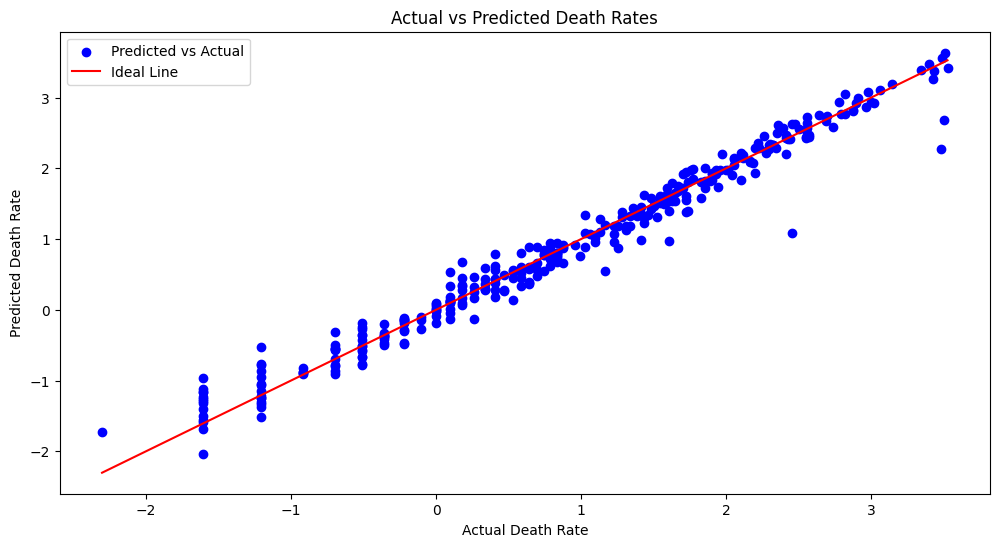

Train RMSE: 0.15913341131189948, Validation RMSE: 0.25570610409684025, Test RMSE: 0.20658930471007297
Train MAE: 0.09882198347368665, Validation MAE: 0.142121555996093, Test MAE: 0.1360177321388581
Train R2: 0.9847876008643716, Validation R2: 0.9539940438584524, Test R2: 0.9745324775614895


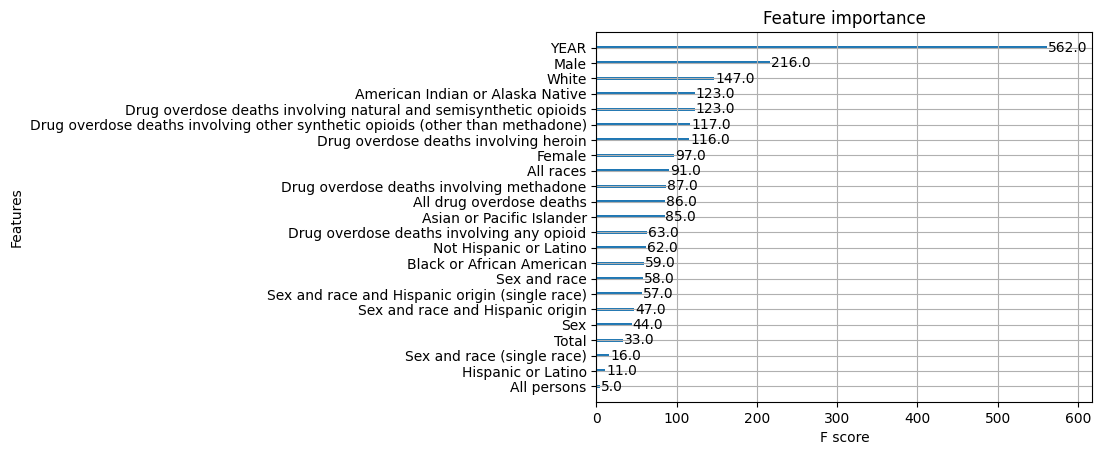

In [ ]:
# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)
y_pred_test = xgb_model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
val_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Validation MAE: {val_mae}, Test MAE: {test_mae}')

# Plotting actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
plt.xlabel('Actual Death Rate')
plt.ylabel('Predicted Death Rate')
plt.legend()
plt.title('Actual vs Predicted Death Rates')
plt.show()

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Validation MAE: {val_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Validation R2: {val_r2}, Test R2: {test_r2}')

s = xgb.plot_importance(xgb_model)
plt.show()


fig = s.get_figure()
fig.savefig("feat.png")

<hr>
<h2> Conclusion<h2/>

<p>
Our model was able to predict with a 97% accuracy the death rates of drug overdoses in the United States from our given dataset. From our bar plot of the feature selections, we can see that the demographic with the most importance is MALE with a 216 F score. White and American indian or alaska native comes in second and third importance.
<p/>
<hr>